In [1]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, roc_auc_score

from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)


In [2]:
dir_path = 'C:/Users/Edward/Documents/Appleolga/Final_pro/model2/'
# dir_path = 'C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/'

In [ ]:
#READING INITIAL TRAIN DATA
data_traff_train = pd.read_sas(dir_path +'train/hash_school_dpi_model_traff.sas7bdat')
data_train = pd.read_sas(dir_path + 'train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
data_traff_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_traff_test.sas7bdat')
data_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_fe_test.sas7bdat')
data_test2 = pd.read_sas(dir_path + 'test/hash_school_dpi_model_test.sas7bdat')

In [ ]:
# #DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

print(data_train.shape)
print(data_traff_train.shape)
data_traff_train = data_traff_train.drop_duplicates()
data_train = data_train.drop_duplicates()
print(data_train.shape)
print(data_traff_train.shape)

data_train = data_train.merge(data_traff_train, on = 'abon_id')
del data_traff_train

print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)
data_test = data_test.drop_duplicates()
data_test2 = data_test2.drop_duplicates()
data_traff_test = data_traff_test.drop_duplicates()
print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)

data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
del data_test2
del data_traff_test

data_train = data_train.astype('float32')
data_test = data_test.astype('float32')

In [3]:
# # # WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# # data_train.to_parquet((dir_path + 'train/data_train.parquet.gzip'),compression='gzip')
# # data_test.to_parquet((dir_path + 'test/data_test.parquet.gzip'),compression='gzip')

# # # READING INITIAL MERGED TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip')

In [75]:
#CHECKING TRAFFIC VARIANCE

traffic_cols = ['traff_m5', 'traff_m4', 'traff_m3','traff_m2','traff_m1']
traff_var = pd.DataFrame(data = data_train[traffic_cols].var(), columns = ['traff_var'])
traff_var.style.format("{:.10}")

In [ ]:
traffic_df_train = data_train[traffic_cols]
# traffic_df_test = data_test[traffic_cols]

In [ ]:
traffic_df_train.describe()

In [ ]:
traffic_df_train.sort_values(by = 'traff_m4', ascending = False)

In [ ]:
traffic_df_train = traffic_df_train.drop(219252)
traffic_df_train.describe()

In [ ]:
traffic_df_train.describe().loc[['mean','25%', '50%', '75%']].plot()

In [ ]:
traffic_df_test.describe().loc[['mean','25%', '50%', '75%']].plot()

In [4]:
data_train = data_train.drop(219252)
print(data_train.shape)
del traffic_df_train

(250016, 911)


NameError: name 'traffic_df_train' is not defined

In [5]:
#FUNCTION TO FIND CATEGORICAL COLUMNS

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list

In [6]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

32
879


In [7]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [8]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [ ]:
data_train_num_outliers_mask = mark_outliers(data_train[num_col_list])
data_train_num_info = df_info(data_train[num_col_list], data_train_num_outliers_mask)
del data_train_num_outliers_mask

In [9]:
# # WRITING AND READING DATA_TRAIN_INFO DF TO PARQUET

# # data_train_num_info.to_parquet((dir_path + 'data_train_num_info.parquet.gzip'),compression='gzip')

data_train_num_info = pd.read_parquet(dir_path +'data_train_num_info.parquet.gzip')

In [10]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [ ]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.4%}"})
data_train_num_info_style

In [11]:
X_train_full = data_train.drop(['target'], axis = 1)

y_train_full = data_train['target']

X_test_full = data_test.drop(['target'], axis = 1)

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.554661, test: 8.655578
R^2 train: 0.595218, test: 0.446710


importance
traff_m1                                 158
traff_m5                                 103
traff_m4                                  48
non_accum_internet_vol_mea_mnt3           48
device_days_usage                         36
bs_succ_rate                              36
dpi_upload                                32
MV_Traf_4G_d_Mb                           32
loc_lon                                   28
non_accum_internet_vol_std_mnt1           27
non_accum_internet_vol_td_mnt3            26
traff_m3                                  25
non_accum_internet_vol_min_mnt3           24
device_price                              22
imei_mean_day_announced                   20
non_accum_internet_vol_min_mnt1           19
non_accum_internet_vol_mea_wk1            18
myvf_day_usage                            18
imei_mean_days_usage                      18
std_paym_6_month                          17
abon_part_td_mnt3                         16
MV_Traf_Cont_inc_s_Cnt                    16
non_accum_internet_vol_mea_mnt1           16
imei_mean_price                           14
MV_ap_innet_out_v                         14
non_accum_internet_vol_max_mnt3           14
non_accum_internet_vol_max_mnt1           13
non_accum_internet_vol_std_mnt3           13
dpi_download                              13
traff_m2                                  13
data_3g_tar_vol_std_mnt1                  12
data_3g_tar_vol_min_mnt1                  12
data_3g_tar_vol_td_mnt3                   12
data_3g_tar_vol_mea_wk1                   12
imei_max_price                            12
DNZ_DAYS_from_last_year5                  11
content_cnt_std_mnt3                      11
data_3g_dou_std_mnt3                      11
Balance_uah                               11
content_cnt_td_mnt3                       11
MV_Traf_3G_d_Mb                           10
dpi_events                                10
data_3g_tv_cnt_mea_mnt3                   10
data_3g_tv_cnt_td_mnt3                    10
voice_mts_out_nrest_partstd_mnt3          10
MV_ap_4G_d                                10
gprs_tar_vol_td_mnt3                       9
sms_in_cnt_std_mnt3                        9
content_cnt_mea_mnt3                       9
pay_avg_td_mnt3                            9
bs_drop_rate                               9
conn_in_uniq_cnt_td_mnt3                   9
MV_Traf_ACCA_out_v_Min                     9
MV_AP_total                                9
MV_Traf_2G_d_Mb                            9
max_paym_6_month                           9
bs_ovrl_OMO_CNT_M2                         9
imei_mean_long_days_usage                  9
voice_mts_out_nwork_partmea_mnt1           8
MV_Traf_innet_out_v_Min                    8
cnt_sms_category_microcred                 8
voice_mts_out_nrest_partmea_mnt3           8
voice_mts_out_drest_partmea_wk1            8
sms_in_cnt_std_mnt1                        8
sum_paym_6_month                           8
voice_mts_in_drest_part_std_mnt3           8
count_day_for_last_paym                    8
voice_mts_in_nwork_part_std_mnt1           8
last_paym                                  8
voice_mts_in_drest_part_mea_wk1            8
MV_dou_4G_d                                8
voice_mts_in_nrest_part_mea_wk1            8
voice_mts_out_dwork_partmax_mnt3           8
num_act_days_td_mnt3                       8
voice_in_life_part_td_mnt3                 8
DNZ_STD_days_closed_loan_year2             8
content_cnt_mea_mnt1                       8
gprs_tar_vol_mea_wk1                       8
all_cnt_std_mnt1                           8
loc_lat                                    8
clc_no_vas_roam_max_mnt1                   8
dpi_duration                               8
com_num_part_td_mnt3                       8
conn_in_uniq_cnt_std_mnt1                  8
voice_mts_out_nwork_partmax_mnt3           7
content_cnt_max_mnt3                       7
voice_mts_in_nrest_part_mea_mnt3           7
bs_ovrl_OMO_CNT_M3                         7
conn_in_uniq_cnt_max_mnt3    

In [ ]:
# VISUALIZING TRAFFIC FEATURES
# traffic is almost completely revolves around zero values. 
# there are big tails. outliers? 

data_train[traffic_cols].plot.box()

In [ ]:
# let's see how traffic values are disperces and how quickly they rich the maximum values

data_train[traffic_cols].describe(percentiles=[0.1, 0.25, 0.5, 0.75, .9, 0.95, 0.96, 0.97, 0.98, 0.99])

In [ ]:
# let's see how the records with outlier traffic values look like

traff_99p_mean = data_train[traffic_cols].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols][data_train[traffic_cols].applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                                  sort_values(by=['traff_m1']).head(10)

In [ ]:
data_train[traffic_cols][data_train[traffic_cols].applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                                  sort_values(by=['traff_m2']).head(10)

In [ ]:
data_train[traffic_cols][data_train[traffic_cols].applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                                  sort_values(by=['traff_m2']).tail(10)

In [ ]:
# There is big dispersion in traffic values. Sometimes it looks like new clients with zero traffic in m5 and big traffic in m1. 
# Sometimes these are the clients that are leaving (big traffic 5 months ago and 0 traffic in m1) and sometimes 
# the dispersion is big without any visible pattern

In [ ]:
# # CALCULATION OF TRAFFIC VARIANCE AND TRAFFIC COLS LIN.REGR. SLOPE FOR EACH OBSERVATION

data_train = data_train.assign(var = data_train[traffic_cols].apply(lambda x: x.var(), axis=1))
data_train = data_train.assign(var_quant = pd.qcut(data_train['var'], 10,labels = False))

data_test = data_test.assign(var = data_test[traffic_cols].apply(lambda x: x.var(), axis=1))
data_test = data_test.assign(var_quant = pd.qcut(data_test['var'], 10,labels = False))

enum = np.arange(1, len(traffic_cols)+1, 1)

data_train = data_train.assign(slope_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_test = data_test.assign(slope_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_train = data_train.assign(interc_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

data_test = data_test.assign(interc_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

In [12]:
# # WRITING TRAIN AND TEST DATA WITH VARIANCE, QUANTILES AND SLOPE TO PARQUET

# data_train.to_parquet((dir_path + 'train/data_train_with_var.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test_with_var.parquet.gzip'),compression='gzip')


# # READING TRAIN AND TEST DATA WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train = pd.read_parquet(dir_path + 'train/data_train_with_var.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test_with_var.parquet.gzip')


In [ ]:
data_train[['slope_traff', 'var']].describe(percentiles=np.arange(0.1, 1, 0.1)).style.format('{:.4f}')

In [ ]:
data_train['slope_traff'].plot.hist(bins = 400,
                                    xlim = (-10,10),
                                    xticks = range(-10,10, 1),
                                    figsize = (9,3))


In [54]:
X_train_full = data_train.drop('target', axis = 1)

y_train_full = data_train['target']

X_test_full = data_test.drop('target', axis = 1)

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.558802, test: 8.658569
R^2 train: 0.594774, test: 0.446328


importance
traff_m1                                 146
traff_m5                                  66
interc_traff                              63
non_accum_internet_vol_mea_mnt3           46
bs_succ_rate                              37
var                                       37
dpi_upload                                36
MV_Traf_4G_d_Mb                           35
non_accum_internet_vol_min_mnt3           33
traff_m4                                  30
device_days_usage                         29
loc_lon                                   29
non_accum_internet_vol_std_mnt1           27
traff_m3                                  22
non_accum_internet_vol_td_mnt3            22
imei_mean_day_announced                   21
imei_mean_days_usage                      21
dpi_download                              19
device_price                              19
traff_m2                                  18
non_accum_internet_vol_mea_wk1            17
non_accum_internet_vol_std_mnt3           17
non_accum_internet_vol_max_mnt1           16
slope_traff                               15
myvf_day_usage                            15
non_accum_internet_vol_min_mnt1           14
imei_mean_price                           14
imei_max_price                            14
abon_part_td_mnt3                         13
data_3g_tar_vol_td_mnt3                   13
non_accum_internet_vol_mea_mnt1           13
num_act_days_td_mnt3                      12
MV_ap_4G_d                                12
non_accum_internet_vol_max_mnt3           12
data_3g_tar_vol_mea_wk1                   12
data_3g_tar_vol_std_mnt3                  12
clc_no_vas_roam_td_mnt3                   12
ks_num_part_td_mnt3                       11
sum_paym_6_month                          11
bs_ovrl_OMO_CNT_M2                        11
Balance_uah                               11
dpi_events                                11
com_num_part_std_mnt1                     11
MV_Traf_2G_d_Mb                           11
bs_of_attemps_all_m1                      10
content_cnt_std_mnt3                      10
data_3g_tv_cnt_td_mnt3                    10
conn_com_part_td_mnt3                     10
voice_in_life_part_td_mnt3                10
max_paym_6_month                          10
data_3g_tv_cnt_mea_mnt3                   10
voice_in_td_cnt_mea_mnt3                  10
DNZ_DAYS_from_last_year5                  10
voice_mts_out_nwork_parttd_mnt3           10
voice_in_mts_avg_dur_td_mnt3              10
voice_in_cmpttrs_avg_durmax_mnt3          10
MV_ap_innet_out_v                          9
std_paym_6_month                           9
voice_out_short_part_mea_mnt3              9
gprs_tar_vol_td_mnt3                       9
voice_in_cmpttrs_avg_durstd_mnt1           9
voice_mts_in_drest_part_td_mnt3            9
gprs_tar_vol_mea_wk1                       9
clc_no_vas_roam_std_mnt3                   9
conn_in_uniq_cnt_std_mnt3                  9
data_3g_tv_cnt_max_mnt1                    9
data_3g_tar_vol_std_mnt1                   9
DNZ_STD_days_closed_loan_year2             9
abon_id                                    9
bs_drop_call_rate                          9
gprs_tar_vol_max_mnt3                      8
imei_mean_long_days_usage                  8
pay_avg_mea_mnt3                           8
voice_mts_out_nrest_partstd_mnt3           8
MV_Traf_ACCA_out_v_Min                     8
MV_Traf_Cont_inc_s_Cnt                     8
voice_mts_out_drest_partmax_mnt3           8
gprs_tar_vol_std_mnt3                      8
sms_in_cnt_mea_mnt3                        8
voice_mts_out_nwork_partmea_wk1            8
last_paym                                  8
MV_ap_pstn_out_v                           8
content_cnt_td_mnt3                        8
voice_in_mts_avg_dur_mea_wk1               8
content_cnt_std_mnt1                       8
sms_in_cnt_td_mnt3                         8
voice_mts_in_dwork_part_std_mnt3           8
data_3g_dou_td_mnt3                        8
days_of_end_last_ppm         

In [55]:
#let;s filter out duplicate stat metric features for features important for general model

data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

f_importance_df[f_importance_df['importance'] > 0].sort_values(by='importance')

f_importance_df = pd.merge(f_importance_df, data_descr, how='left', left_index=True, right_on='feature')

f_importance_df.loc[f_importance_df['descr'].isna(),'descr'] = f_importance_df.loc[f_importance_df['descr'].isna(), 'feature']

f_importance_df = f_importance_df.assign(feature_clear = f_importance_df['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

f_importance_df['feature_clear'] = f_importance_df.feature_clear.apply(lambda x: re.sub(escaped_expression, '', str(x)))

f_importance_df = f_importance_df.reset_index(drop=True)

In [59]:
general_m_cols_to_use = list(f_importance_df.loc[f_importance_df.groupby(["feature_clear"])["importance"].idxmax()]['feature'])

In [61]:
len(general_m_cols_to_use)

323

In [64]:
X_train_full = data_train[general_m_cols_to_use]

y_train_full = data_train['target']

X_test_full = data_test[general_m_cols_to_use]

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.644755, test: 8.655094
R^2 train: 0.585506, test: 0.446772


importance
traff_m1                                 162
traff_m5                                  88
interc_traff                              81
non_accum_internet_vol_mea_mnt3           81
bs_succ_rate                              56
MV_Traf_4G_d_Mb                           49
traff_m3                                  48
device_days_usage                         45
loc_lon                                   44
dpi_upload                                43
var                                       43
traff_m4                                  43
slope_traff                               41
myvf_day_usage                            39
data_3g_tar_vol_td_mnt3                   39
content_cnt_std_mnt3                      37
MV_ap_4G_d                                36
device_price                              35
imei_max_price                            35
imei_mean_day_announced                   32
sum_paym_6_month                          32
data_3g_dou_td_mnt3                       31
imei_mean_days_usage                      31
imei_mean_price                           30
voice_in_td_cnt_mea_mnt3                  29
MV_Traf_Cont_inc_s_Cnt                    29
traff_m2                                  29
DNZ_DAYS_from_last_year5                  28
voice_out_td_cnt_std_mnt1                 27
dpi_download                              26
num_act_days_td_mnt3                      26
all_cnt_mea_wk1                           26
data_3g_tv_cnt_mea_mnt3                   26
abon_part_td_mnt3                         25
bs_ovrl_OMO_CNT_M1                        25
clc_no_vas_roam_td_mnt3                   25
sms_in_cnt_mea_mnt3                       25
MV_Traf_2G_d_Mb                           24
voice_out_cmpttrs_avg_dustd_mnt3          24
pay_avg_mea_mnt3                          24
bs_of_succ_m1                             23
imei_mean_long_days_usage                 23
vas_clc_max_mnt3                          23
all_clc_mea_wk1                           23
conn_in_uniq_cnt_std_mnt3                 22
loc_lat                                   22
voice_mts_in_drest_part_td_mnt3           22
voice_in_cmpttrs_avg_durmax_mnt3          22
last_paym                                 21
Balance_uah                               21
bs_ovrl_OMO_CNT_M2                        21
all_home_clc_td_mnt3                      20
MV_Traf_3G_d_Mb                           20
gprs_tar_vol_mea_wk1                      20
ks_num_part_td_mnt3                       19
voice_in_mts_avg_dur_td_mnt3              19
voice_in_short_part_mea_mnt3              19
pay_max_mea_mnt3                          19
dpi_duration                              19
com_num_part_std_mnt1                     19
cnt_sms_category_microcred                19
content_clc_std_mnt3                      18
MV_ap_innet_out_v                         18
bs_drop_call_rate                         18
abon_id                                   18
voice_mts_out_nwork_parttd_mnt3           17
MV_Traf_omo_out_v_Min                     17
voice_out_short_part_mea_mnt3             17
bs_recall_rate                            17
lt                                        16
sms_clc_td_mnt3                           16
loc_cnt_events                            16
bs_of_attemps_all_m1                      16
voice_out_tar_dur_max_mnt3                16
loc_market_share                          15
voice_in_fix_tar_dur_mea_mnt3             15
pay_sum_mea_mnt3                          15
conn_out_uniq_cnt_std_mnt1                15
bs_ovrl_OMO_CNT_M3                        15
dpi_events                                15
MV_Traf_omo_inc_v_Min                     14
MV_dou_data                               14
MV_Traf_innet_inc_v_Min                   13
bs_drop_rate                              13
voice_in_kievstar_part_td_mnt3            13
MV_dou_4G_d                               13
tsoa_call_cnt                             13
MV_ARPU                                   13
MV_Traf_inc_s_Cnt            

In [65]:
# let's filter out features which do not affect the model
general_m_cols_to_use = list(f_importance_df[f_importance_df['importance'] > 0].index)
len(general_m_cols_to_use)

205

In [256]:
X_train_full = data_train[general_m_cols_to_use]

y_train_full = data_train['target']

X_test_full = data_test[general_m_cols_to_use]

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))

RMSE train: 7.644755, test: 8.655094
R^2 train: 0.585506, test: 0.446772


In [ ]:
# model perfomance has slightly improved (8.655578 vs 8.655094)
# and new features - var, intercept and slope_traff are among the 13 most important now

In [68]:
# let's filter out records with big traffic variance and see how the model performs
var_quant_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
var_quant_error_df = pd.DataFrame(index= var_quant_list[::-1], columns=['RMSE_train', 'RMSE_test', 'RMSE_by_quant'])

while len(var_quant_list):

    X_train_full = data_train[data_train['var_quant'].isin(var_quant_list)][general_m_cols_to_use]

    print(X_train_full.shape)

    y_train_full = data_train[data_train['var_quant'].isin(var_quant_list)]['target']

    X_test_full = data_test[data_test['var_quant'].isin(var_quant_list)][general_m_cols_to_use]

    y_test_full = data_test[data_test['var_quant'].isin(var_quant_list)]['target']
    
    X_train_quant = data_train[data_train['var_quant'] == max(var_quant_list)][general_m_cols_to_use]

    y_train_quant = data_train[data_train['var_quant'] == max(var_quant_list)]['target']

    model = ltb.LGBMRegressor(objective ='regression',
                              random_state = 0)


    model.fit(X_train_full,y_train_full)

    y_train_pred = model.predict(X_train_full)
    y_test_pred = model.predict(X_test_full)
    y_pred_by_quant = model.predict(X_train_quant)

    var_quant_error_df.loc[max(var_quant_list)] = [mean_squared_error(y_train_full, y_train_pred, squared = False),
                                                   mean_squared_error(y_test_full, y_test_pred, squared = False),
                                                   mean_squared_error(y_train_quant, y_pred_by_quant, squared = False)]
    del var_quant_list[-1]

(250016, 205)
(225014, 205)
(200013, 205)
(175011, 205)
(150010, 205)
(125008, 205)
(100007, 205)
(75005, 205)
(50004, 205)
(25002, 205)


In [ ]:
var_quant_error_df['RMSE_by_quant'].plot(kind='bar')

In [69]:
# most of the error lies in the records with biggest traffic variance per record. 
# Starting from 70th and lower variance quantiles RMSE drops up to 7
var_quant_error_df

RMSE_train RMSE_test RMSE_by_quant
9   7.644755  8.655094     17.278125
8   5.329379  6.195578     10.484229
7   4.076272  4.795913      7.117087
6   3.295405   3.90143      5.198832
5   2.754611  3.310261      4.149079
4   2.290451  2.846875      3.045646
3   1.963043  2.459983      2.360574
2   1.732406  2.071925       1.89556
1   1.539444   1.88536      1.587594
0    1.31528  1.866575       1.31528

In [70]:
# let's find and look at the traffic linregress line slope outliers 

from scipy import stats

data_train = data_train.assign(z_score_slope = scipy.stats.zscore(data_train['slope_traff']))
                                                                
data_train = data_train.assign(big_slope = data_train['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 3) else 0))

data_test = data_test.assign(z_score_slope = scipy.stats.zscore(data_test['slope_traff']))
                                                                
data_test = data_test.assign(big_slope = data_test['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 3) else 0))

In [71]:
data_train.groupby('big_slope')['abon_id'].count()

big_slope
0    244119
1      5897
Name: abon_id, dtype: int64

In [72]:
# let's see how model performs for regular slope and outlier slope records
big_slope_list = [0, 1]
big_slope_error_df = pd.DataFrame(index= big_slope_list, columns=['RMSE_train', 'RMSE_test', 'RMSE_by_bs'])

while len(big_slope_list):

    X_train_full = data_train[data_train['big_slope'].isin(big_slope_list)].drop('target', axis = 1)

    print(X_train_full.shape)

    y_train_full = data_train[data_train['big_slope'].isin(big_slope_list)]['target']

    X_test_full = data_test[data_test['big_slope'].isin(big_slope_list)].drop('target', axis = 1)

    y_test_full = data_test[data_test['big_slope'].isin(big_slope_list)]['target']
    
    X_train_bs = data_train[data_train['big_slope'] == max(big_slope_list)].drop('target', axis = 1)

    y_train_bs = data_train[data_train['big_slope'] == max(big_slope_list)]['target']

    model = ltb.LGBMRegressor(objective ='regression',
                              random_state = 0)


    model.fit(X_train_full,y_train_full)

    y_train_pred = model.predict(X_train_full)
    y_test_pred = model.predict(X_test_full)
    y_pred_by_bs = model.predict(X_train_bs)

    big_slope_error_df.loc[max(big_slope_list)] = [mean_squared_error(y_train_full, y_train_pred, squared = False),
                                                   mean_squared_error(y_test_full, y_test_pred, squared = False),
                                                   mean_squared_error(y_train_bs, y_pred_by_bs, squared = False)]
    del big_slope_list[-1]

(250016, 916)
(244119, 916)


In [73]:
# so, most of the prediction error lies in the records lies in the records with big variance, 
# with the primary focus on extremely big linregress line slope samples
big_slope_error_df

RMSE_train RMSE_test RMSE_by_bs
0   6.791115  7.895802   6.791115
1   7.562196  8.659715  19.762794

In [76]:
# Let's see which features might predict big slope feature 

X_train_full = data_train.drop(traffic_cols + ['target', 'var', 'var_quant', 'slope_traff', 'z_score_slope', 'big_slope'], 
                               axis = 1)

y_train_full = data_train['big_slope']


model = ltb.LGBMClassifier(objective ='binary',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_full, y_train_pred)

0.9692289882338824

In [77]:
big_slope_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
big_slope_features = big_slope_features[big_slope_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)

big_slope_features = big_slope_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_slope_features['importance'].cumsum())
big_slope_features['cum_sum']  = big_slope_features['cum_sum']/big_slope_features['importance'].sum()

print(big_slope_features.shape)
big_slope_features.style.format({'cum_sum': "{:.2%}"})

(560, 2)


In [78]:
# We see that there are some duplicate features, which are stat metrics of the same variable. 
# Let's filter out the ones, that have lower importance and keep only most important ones

big_slope_features = pd.merge(big_slope_features, data_descr, how='left', left_index=True, right_on='feature')

big_slope_features.loc[big_slope_features['descr'].isna(), 
                        'descr'] = big_slope_features.loc[big_slope_features['descr'].isna(), 'feature']

big_slope_features = big_slope_features.assign(feature_clear = big_slope_features['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

big_slope_features['feature_clear'] = big_slope_features.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

slope_cols_to_use = list(big_slope_features.loc[big_slope_features.\
                                                groupby(["feature_clear"])["importance"].idxmax()]['feature'])


In [79]:
slope_cols_to_use = list(big_slope_features.groupby('feature_clear')['feature'].max('importance').values)

print(len(slope_cols_to_use))
# sorted(slope_cols_to_use)

184


In [83]:
big_slope_features.loc[big_slope_features.groupby(["feature_clear"])["importance"].idxmax()].\
                                          sort_values(by='importance', ascending=False)

importance   cum_sum                           feature  \
NaN           489  0.163000                      interc_traff   
878.0         141  0.210000                      dpi_download   
601.0         137  0.255667   non_accum_internet_vol_mea_mnt3   
159.0          30  0.331000                   MV_Traf_4G_d_Mb   
877.0          28  0.350333                        dpi_upload   
6.0            22  0.381000                 device_days_usage   
4.0            22  0.373667                                lt   
897.0          21  0.388000              imei_mean_days_usage   
254.0          15  0.393000                  sum_paym_6_month   
2.0            13  0.410333                       Balance_uah   
876.0          13  0.406000                      dpi_duration   
285.0          13  0.401667      voice_out_short_part_td_mnt3   
644.0          13  0.397333              data_3g_dou_std_mnt3   
879.0          12  0.430333                        dpi_events   
270.0          12  0.418333                bs_ovrl_OMO_CNT_M3   
727.0          12  0.414333          clc_no_vas_roam_mea_mnt1   
445.0          12  0.422333   voice_mts_out_drest_parttd_mnt3   
535.0          11  0.448667                   vas_clc_td_mnt3   
209.0          11  0.452333                 MV_ap_innet_out_v   
385.0          11  0.445000      voice_in_mts_avg_dur_td_mnt3   
667.0          11  0.467000              content_cnt_mea_mnt1   
217.0          11  0.437667                        MV_ot_4G_d   
655.0          11  0.463333           data_3g_tar_vol_td_mnt3   
49.0           11  0.456000                    bs_recall_rate   
899.0          11  0.459667                   imei_mean_price   
901.0          10  0.473667           imei_mean_day_announced   
234.0          10  0.487000               bs_day_of_change_tp   
365.0          10  0.477000   voice_in_cmpttrs_td_cnt_td_mnt3   
685.0          10  0.490333               content_clc_td_mnt3   
3.0            10  0.470333                             TM_ID   
835.0           9  0.502333                 abon_part_td_mnt3   
898.0           9  0.493333         imei_mean_long_days_usage   
565.0           9  0.505333                   pay_avg_td_mnt3   
455.0           9  0.508333   voice_mts_in_nrest_part_td_mnt3   
771.0           8  0.519000                  all_cnt_mea_mnt3   
515.0           8  0.521667                sms_in_cnt_td_mnt3   
34.0            8  0.516333                      device_price   
37.0            7  0.552000                           loc_lat   
690.0           7  0.549667        conn_out_uniq_cnt_std_mnt1   
791.0           7  0.563667                  all_clc_mea_mnt3   
273.0           7  0.528667                bs_ovrl_OMO_SUM_M2   
155.0           7  0.556667                   MV_Traf_2G_d_Mb   
710.0           7  0.545000            conn_com_part_std_mnt1   
884.0           7  0.566000    DNZ_STD_days_closed_loan_year2   
577.0           7  0.538000                  pay_sum_mea_mnt1   
485.0           7  0.559000           voice_in_td_cnt_td_mnt3   
631.0           7  0.547333             gprs_tar_vol_mea_mnt3   
375.0           6  0.606000   voice_out_cmpttrs_td_cnttd_mnt3   
263.0           6  0.598000                         last_paym   
80.0            6  0.628000           cnt_sms_category_poshta   
323.0           6  0.612000       voice_in_life_part_min_mnt3   
335.0           6  0.590000    voice_in_kievstar_part_td_mnt3   
305.0           6  0.588000      voice_in_fix_tar_dur_td_mnt3   
162.0           6  0.596000            MV_Traf_Cont_inc_s_Cnt   
295.0           6  0.592000       voice_in_short_part_td_mnt3   
48.0            6  0.614000                      bs_drop_rate   
38.0            6  0.584000                           loc_lon   
35.0            6  0.610000                    loc_cnt_events   
725.0           6  0.624000              com_num_part_td_mnt3   
268.0           6  0.626000           BS_OVERBUNDLE_MB_CNT_M3   
44.0            6  0.602000              b

In [84]:
#let's combine two feature lists to explore important feature further 

cols_to_use = general_m_cols_to_use + slope_cols_to_use
cols_to_use = set(cols_to_use)
len(cols_to_use)

258

In [88]:
# Columns important for predicting big slope
differences = list(set(slope_cols_to_use)-set(general_m_cols_to_use))
sorted(differences)

['BS_OVERBUNDLE_MB_SUM_M3',
 'DNZ_STD_days_closed_loan_year5',
 'MV_ARPU_2G_d_Traf',
 'MV_ARPU_omo_out_s_Traf',
 'MV_ARPU_pstn_out_v_Traf',
 'MV_Traf_mn_out_s_Cnt',
 'MV_Traf_omo_out_s_Cnt',
 'MV_dou_Roam',
 'MV_dou_net',
 'all_clc_td_mnt3',
 'all_cnt_td_mnt3',
 'ama_volume_std_mnt1',
 'bs_count_ppm_mn3',
 'cnt_bank_sms_category_alfabank',
 'cnt_bank_sms_category_kredobank',
 'cnt_bank_sms_category_mtbbank',
 'cnt_bank_sms_category_otpbank',
 'cnt_bank_sms_category_pumbbank',
 'cnt_bank_sms_category_sberbank',
 'cnt_bank_sms_category_ukrgasbank',
 'cnt_bank_sms_category_ukrsibbank',
 'cnt_sms_category_taxi',
 'com_num_part_td_mnt3',
 'conn_in_uniq_cnt_td_mnt3',
 'conn_out_uniq_cnt_td_mnt3',
 'content_clc_td_mnt3',
 'content_cnt_td_mnt3',
 'data_3g_tv_cnt_td_mnt3',
 'device_brand_xiaomi',
 'device_type_tablet',
 'goodok_clc_td_mnt3',
 'gprs_clc_td_mnt3',
 'gprs_tar_vol_td_mnt3',
 'is_max_paym',
 'non_accum_internet_vol_td_mnt3',
 'pay_avg_td_mnt3',
 'pay_max_td_mnt3',
 'pay_sum_td_mnt3'

In [ ]:
# 'non_accum_internet_vol_mea_mnt3' seems to be one of the most importnant features alongside traffic and dpi ones
# both for general model and big slope prediction

# Let's explore it

In [91]:
data_train['non_accum_internet_vol_mea_mnt3'].describe()

count    2.492570e+05
mean     7.135782e+16
std               inf
min      0.000000e+00
25%      8.814255e+11
50%      6.421864e+13
75%      2.166840e+15
max      2.182766e+20
Name: non_accum_internet_vol_mea_mnt3, dtype: float64

In [97]:
#Let's create logariphmic bins in order to be able to compare it to the target

symlog = data_train['non_accum_internet_vol_mea_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_train = data_train.assign(non_accum_internet_vol_mea_mnt3_log = symlog)

symlog = data_test['non_accum_internet_vol_mea_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_test = data_test.assign(non_accum_internet_vol_mea_mnt3_log = symlog)

data_train = data_train.assign(non_accum_internet_vol_mea_mnt3_log_bins = pd.cut(data_train['non_accum_internet_vol_mea_mnt3_log'], 
                                                                                bins=range(0, 21)))

data_test = data_test.assign(non_accum_internet_vol_mea_mnt3_log_bins = pd.cut(data_test['non_accum_internet_vol_mea_mnt3_log'], 
                                                                                bins=range(0, 21)))

del symlog

In [98]:
data_train = data_train.assign(big_var = data_train.apply(lambda x: 0 if (x['var_quant'] < 8) else 1, axis=1))
data_test = data_test.assign(big_var = data_test.apply(lambda x: 0 if (x['var_quant'] < 8) else 1, axis=1))

In [99]:
 def ratio_diagram(df, values_col, index_col, columns_cols, comparison_names, agg_func = 'count') :
        
    pivot_df = pd.pivot_table(df, 
                              values=values_col,
                              index=index_col,
                              columns=columns_cols, 
                              aggfunc=agg_func)
    
    pivot_df.columns = comparison_names
    pivot_df = pivot_df.assign(ratio = pivot_df[comparison_names[1]]/pivot_df[comparison_names[0]])


    pivot_df.sort_values(by = 'ratio', ascending = False)

    ax1 = pivot_df.loc[:, comparison_names].plot(kind = 'bar',
                                                 figsize = (10,5),
                                                 rot = 90,
                                                 sharex = True)


    ax1 = pivot_df['ratio'].plot(secondary_y=True,
                                 colormap = 'ocean',
                                 rot = 90,
                                 legend = True,
                                 sharex = True);
    
    plt.show()
    
    return pivot_df
    
    

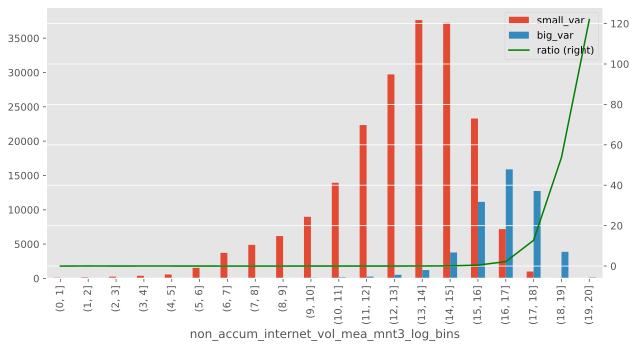

In [101]:
# For big 'non_accum_internet_vol_mea_mnt3' values there are considerably more records with big traffic variance, 
# than with small variance

ratio_df = ratio_diagram(data_train, 
                         ['abon_id'], 
                         ['non_accum_internet_vol_mea_mnt3_log_bins'], 
                         ['big_var'], 
                         ['small_var', 'big_var'])

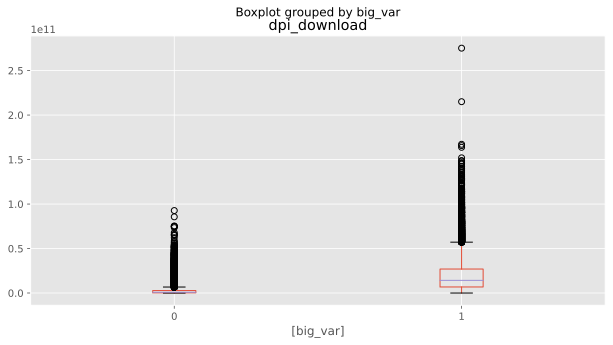

In [102]:
#dpi_download value for bid variance records is considerably bigger and much more spred out
# while for small variance it is concentrated around zero values
data_train.boxplot(column='dpi_download', by=['big_var'])

In [103]:
#FUNCTION TO FIND CATEGORICAL COLUMNS
def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list

In [104]:
cat_num_col_list = find_cat_cols(data_train[cols_to_use])
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

9
249


In [105]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [119]:
data_train_num = data_train[num_col_list]
data_test_num = data_test[num_col_list]
data_train_num_outliers_mask = mark_outliers(data_train_num)

100
200


In [120]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        perc_nan_plus_univalue = perc_nans+freq_value_count
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  '%nan+univ': perc_nan_plus_univalue,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [121]:
data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
del data_train_num_outliers_mask

In [109]:
#let's see how the pre-selected features are correlated with the target
data_train_num_corr = data_train[num_col_list + ['target']].corr()

In [110]:
# # WRITING AND READING DATA_TRAIN TARGET CORRELATION DF TO PARQUET

# data_train_num_corr.to_parquet((dir_path + 'data_train_num_corr2.parquet.gzip'),compression='gzip')

data_train_num_corr = pd.read_parquet(dir_path +'data_train_num_corr2.parquet.gzip')


In [122]:
# ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)


In [123]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [136]:
data_train_num_info = data_train_num_info.merge(f_importance_df, right_index=True, left_on='col')

In [137]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nan+univ', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans', '%nan+univ'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.4%}",
                                                        '%of_unfr_univalue': "{:.4%}",
                                                        '%outliers': "{:.4%}",
                                                        '%nans': "{:.4%}",
                                                        '%nan+univ': "{:.4%}",
                                                        'target': "{:.4f}"})
data_train_num_info_style

In [158]:
# some of the features and almost 100% nan or zero values while their importance for the model is very low
# let's see if they can be grouped in any way

empty_cols = list(data_train_num_info[(data_train_num_info['%nan+univ'] > 0.9) & 
                                      (data_train_num_info['importance'] == 1)]['col'])
empty_cols

# well, not really.. 

['MV_ARPU_Cont_out_v_Traf',
 'MV_dou_Roam_d',
 'MV_ap_3G_d',
 'MV_ot_s',
 'MV_ot_mn_out_v',
 'MV_ot_Other',
 'MV_ot_omo_out_v',
 'MV_ot_innet_out_v',
 'cnt_unq_category_poshta',
 'cnt_unq_category_women',
 'bs_arpu_change_tp',
 'bs_count_change_tp',
 'Internet',
 'tsoa_chat_cnt',
 'AMA',
 'Good_deed',
 'Minutes']

In [162]:
# there is an interesting feature - 'cnt_sms_category_microcred', which is 93% nan, but its importance is quite high
# as for almost emlty feature
data_train['cnt_sms_category_microcred'].value_counts() 

1.206949     2369
0.480453     1964
0.000000     1570
1.921812      996
2.590290      642
3.786566      606
3.210402      602
4.324077      501
4.827796      427
5.301898      415
5.749902      372
6.174761      340
6.578965      270
7.687248      236
6.964623      233
7.333536      219
8.354249      177
8.027098      171
8.669721      160
8.974412      158
9.831324      152
9.269116      144
10.100026     143
9.554543      139
10.862540     134
12.225565     131
11.568144     127
12.841608     124
10.361161     124
11.338681     121
11.103587     117
10.615193     111
12.435219     109
12.011325      90
11.792268      90
12.640500      83
13.232033      81
13.421684      77
14.320091      74
13.038728      72
14.490680      64
13.607832      63
13.970174      61
13.790618      59
15.459252      54
15.303924      49
16.487198      45
14.146626      44
17.165565      44
14.658495      43
14.986197      42
14.823637      42
15.612327      41
15.146265      40
16.203457      39
16.058720 

In [165]:
data_train[~data_train['cnt_sms_category_microcred'].isna()]['var'].sort_values(ascending=False)

index
115812    2.090057e+05
102370    4.444002e+03
231856    3.948212e+03
95830     3.517312e+03
225065    3.246111e+03
              ...     
206703    8.598846e-07
220643    5.352193e-07
223080    3.924408e-07
237169    2.036110e-08
145379    1.734939e-08
Name: var, Length: 16850, dtype: float64

In [190]:
min_f = data_train['cnt_sms_category_microcred'].min()
max_f = data_train['cnt_sms_category_microcred'].max()

plt.figure(figsize=(10, 5))
plt.scatter(x=data_train['cnt_sms_category_microcred'],
            y=data_train['target'],
            c=data_train['big_slope']);

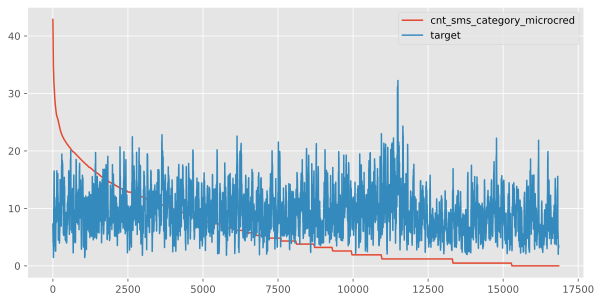

In [197]:
temp = data_train[~data_train['cnt_sms_category_microcred'].isna()][['target', 'cnt_sms_category_microcred']].\
            sort_values(by='cnt_sms_category_microcred', ascending=False).reset_index(drop=True)

temp = temp.rolling(20, center = True, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(temp['cnt_sms_category_microcred'], label="cnt_sms_category_microcred")
plt.plot(temp['target'], label="target")

plt.legend();

In [ ]:
print('low target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape[0])


#PRINTING INFO DF FOR LOW TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'col', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.4f}"})
data_train_num_info_style

In [ ]:
print('high target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape[0])

#PRINTING INFO DF FOR HIGH TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

In [ ]:
#CHOOSING THE FEATURES WITH AT LEAST 0.2 CORRELATION COEFF WITH THE TARGET
# AND LESS THAN 60% OF MISSINGS

num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.6)]['col'].to_list()
len(num_cols_to_use)

In [ ]:
sorted(num_cols_to_use)

Text(0.5, 1.0, 'small_var')

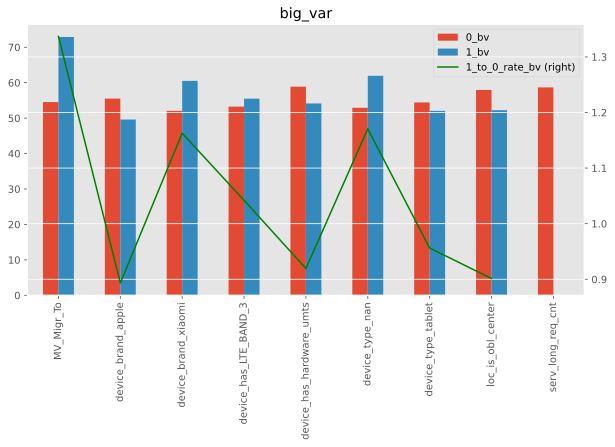

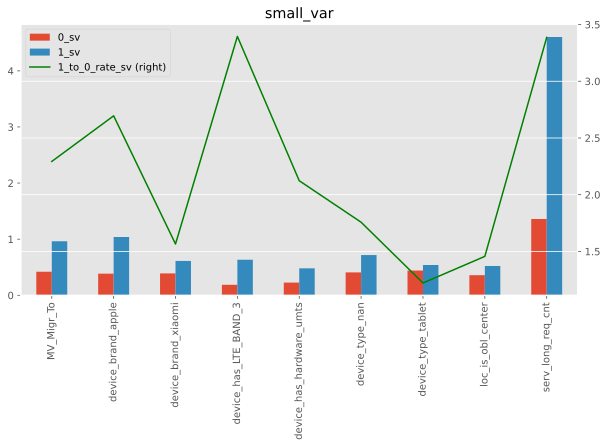

In [198]:
# VISUALZING TARGET DIFFERENCE RATE FOR CATEGORICAL COLUMNS

target_by_cat_cols = pd.DataFrame(index=cat_col_list, 
                                  columns=['0_bv', '1_bv', '1_to_0_rate_bv','0_sv', '1_sv', '1_to_0_rate_sv'])

for col in cat_col_list:
    temp = data_train[data_train['var_quant'] > 7].pivot_table(columns=col,
                                                               values='var', 
                                                               aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_bv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_bv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_bv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = np.nan
        
    temp = data_train[data_train['var_quant'] <= 7].pivot_table(columns=col,
                                                                values='var', 
                                                                aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_sv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_sv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_sv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = np.nan


ax1 = target_by_cat_cols.sort_index().loc[:, ['0_bv', '1_bv']].plot(kind = 'bar',
                                                                       figsize = (10,5),
                                                                       rot = 90,
                                                                       sharex = True)


ax1 = target_by_cat_cols.sort_index()['1_to_0_rate_bv'].plot(secondary_y=True,
                                                                colormap = 'ocean',
                                                                rot = 90, 
                                                                legend = True,
                                                                sharex = True);

ax1.set_title('big_var')
    
ax2 = target_by_cat_cols.sort_index().loc[:, ['0_sv', '1_sv']].plot(kind = 'bar',
                                                                    figsize = (10,5),
                                                                    rot = 90,
                                                                    sharex = True);

ax2 = target_by_cat_cols.sort_index()['1_to_0_rate_sv'].plot(secondary_y=True,
                                                             colormap = 'ocean',
                                                             rot = 90,
                                                             legend = True,
                                                             sharex = True);

ax2.set_title('small_var')

In [199]:
target_by_cat_cols.sort_values(by='1_to_0_rate_bv')

0_bv       1_bv 1_to_0_rate_bv      0_sv  \
device_brand_apple        55.515495  49.594833       0.893351  0.385513   
loc_is_obl_center         57.951309  52.231514         0.9013   0.35827   
device_has_hardware_umts  58.882187  54.137127       0.919414  0.226451   
device_type_tablet        54.426224  52.043221       0.956216   0.44163   
device_has_LTE_BAND_3     53.248413  55.484306        1.04199  0.186708   
device_brand_xiaomi       52.039097  60.505695       1.162697  0.390896   
device_type_nan           52.904982  61.934895       1.170682  0.408116   
MV_Migr_To                54.524891  72.891586        1.33685  0.419742   
serv_long_req_cnt         58.665257        NaN            NaN  1.359197   

                              1_sv 1_to_0_rate_sv  
device_brand_apple         1.03901       2.695137  
loc_is_obl_center         0.521819       1.456496  
device_has_hardware_umts   0.48077       2.123066  
device_type_tablet        0.539647       1.221944  
device_has_LTE_BAND_3     0.633882       3.395049  
device_brand_xiaomi       0.611936        1.56547  
device_type_nan           0.717151       1.757224  
MV_Migr_To                0.962498       2.293072  
serv_long_req_cnt         4.602863       3.386456

In [200]:
# seems like 'serv_long_req_cnt' is a good predictor for bigger target. Let's explore
print(data_train.groupby(['big_var','serv_long_req_cnt'])['abon_id'].count())

#nope, it is almost 100% either NAN or zero. It can be misleading for the model
# let's check if there any other such columns


big_var  serv_long_req_cnt
0        0.0                  20454
         1.0                      4
1        0.0                   8864
Name: abon_id, dtype: int64


In [204]:
def df_info (df, col_list):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%nans'])
    
    df_length = df.shape[0]
    
    for col in col_list:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_nans = df[col].isnull().sum()/df_length
        perc_nan_univ = perc_nans + freq_value_count
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%nans': perc_nans,
                                  '%nan+univ':perc_nan_univ, 
                                  'freq_value': freq_value}, 
                                  ignore_index=True)
        
    return df_info.sort_values(by = ['%nans'], ascending=False) 



In [205]:
cat_cols_df_info = df_info(data_train, cat_col_list)
cat_cols_df_info = cat_cols_df_info.merge(f_importance_df, right_index=True, left_on='col')

cat_cols_df_info_style = cat_cols_df_info.sort_values(by = '%nan+univ', ascending=False).\
                                          style.apply(highlight_perc,
                                          subset=['%nans','%nan+univ'],
                                          **{'q': 0.75}).\
                                          format({'%of_fr_univalue': "{:.2%}",
                                                  '%of_unfr_univalue': "{:.2%}",
                                                  '%nans': "{:.2%}",
                                                  '%nan+univ': "{:.4%}",
                                                  'target': "{:.2f}"})
cat_cols_df_info_style

In [203]:
# serv_long_req_cnt was the only one, let's delete it 
cols_to_delete = ['serv_long_req_cnt']
cat_col_list = [x for x in cat_col_list if x not in cols_to_delete]
cat_col_list


['device_has_hardware_umts',
 'device_brand_xiaomi',
 'device_type_nan',
 'device_brand_apple',
 'device_type_tablet',
 'MV_Migr_To',
 'loc_is_obl_center',
 'device_has_LTE_BAND_3']

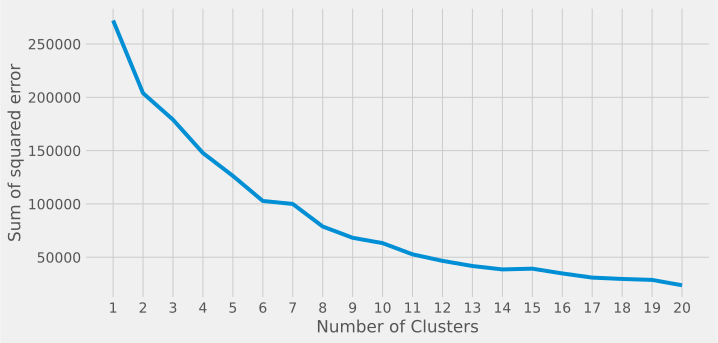

In [206]:
#Let's see if these categorical features form any meaningful groups 
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = data_train[cat_col_list].fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = data_train[cat_col_list].fillna(0)
X_test_big_var = data_test[cat_col_list].fillna(0)

kmeans_batch = MiniBatchKMeans(n_clusters=9, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_train_big_var)

y_kmeans_batch_test = kmeans_batch.predict(X_test_big_var)

data_train = data_train.assign(cluster = y_kmeans_batch_train)
data_test = data_test.assign(cluster = y_kmeans_batch_test)

del X_train_big_var, X_test_big_var,y_kmeans_batch_train,y_kmeans_batch_test


In [ ]:
# CHECKING MULTICOLLENEARITY IN DATA

def highlight_corr_06_plus(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_high = s >= 0.6
    return ['background-color: red' if v else '' for v in is_high]

num_cols_to_use_wo_traffic = [x for x in num_cols_to_use if x not in traffic_cols]

collinear_cols_style = data_train_num_corr.loc[num_cols_to_use_wo_traffic, num_cols_to_use_wo_traffic].\
                                           style.apply(highlight_corr_06_plus).format("{:.2%}")


collinear_cols_style

In [ ]:
data_train_num_corr.loc[num_cols_to_use_wo_traffic, num_cols_to_use_wo_traffic]['dpi_duration'].sort_values()

In [ ]:
data_train_num_corr.loc[num_cols_to_use_wo_traffic, num_cols_to_use_wo_traffic]['MV_ARPU'].sort_values()

In [ ]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [ ]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[totals_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[totals_for_pca].fillna(0))

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")


In [ ]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[dpi_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[dpi_for_pca].fillna(0))

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")

In [ ]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[totals_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[totals_for_pca].fillna(0))

pca_train = PCA(n_components = 1, random_state=3)
pca_test = PCA(n_components = 1, random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_test_std)



sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train[dpi_for_pca].fillna(0))
X_test_std = sc_x_traf.fit_transform(data_test[dpi_for_pca].fillna(0))

pca_train = PCA(n_components = 2, random_state=3)
pca_test = PCA(n_components = 2, random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_test_std)


del(X_train_std, X_test_std)

In [ ]:
generated_features = ['var','slope_traff', 'z_score_slope', 'big_slope','non_accum_internet_vol_td_mnt3_log',
                      'non_accum_internet_vol_td_mnt3_log_bins', 'big_var', 'cluster']

generated_features1 = ['var','slope_traff', 'z_score_slope', 'big_slope','non_accum_internet_vol_td_mnt3_log',
                       'big_var', 'cluster']


generated_features2 = ['var','slope_traff', 'cluster']

In [ ]:
# cols_for_model = list(set(num_col_list + cat_col_list + generated_features1))
cols_for_model = list(set(num_cols_to_use + cat_col_list + generated_features1))
cols_for_model = list(set(num_cols_to_use + cat_col_list + generated_features2))
cols_for_model = num_cols_to_use

In [ ]:
len(cols_for_model)

In [ ]:
len(general_m_cols_to_use)

In [ ]:
sorted(general_m_cols_to_use)

In [ ]:
# cols_to_use = general_m_cols_to_use + slope_cols_to_use

In [208]:
cols_to_use

{'AMA',
 'BS_OVERBUNDLE_MB_CNT_M1',
 'BS_OVERBUNDLE_MB_CNT_M2',
 'BS_OVERBUNDLE_MB_CNT_M3',
 'BS_OVERBUNDLE_MB_SUM_M1',
 'BS_OVERBUNDLE_MB_SUM_M3',
 'Balance_uah',
 'DNZ_COUNT_closed_loan_year1',
 'DNZ_DAYS_from_last_year1',
 'DNZ_DAYS_from_last_year5',
 'DNZ_MAX_days_closed_loan_year1',
 'DNZ_MEAN_days_closed_loan_year1',
 'DNZ_MEAN_days_open_loan_year1',
 'DNZ_MIN_days_closed_loan_year1',
 'DNZ_STD_days_closed_loan_year5',
 'GBA_remain_days',
 'Good_deed',
 'Internet',
 'MV_AP_total',
 'MV_ARPU',
 'MV_ARPU_2G_d_Traf',
 'MV_ARPU_3G_d_Traf',
 'MV_ARPU_4G_d_Traf',
 'MV_ARPU_Cont_out_s_Traf',
 'MV_ARPU_Cont_out_v_Traf',
 'MV_ARPU_Roam_d_Traf',
 'MV_ARPU_innet_out_s_Traf',
 'MV_ARPU_innet_out_v_Traf',
 'MV_ARPU_mn_out_s_Traf',
 'MV_ARPU_omo_out_s_Traf',
 'MV_ARPU_omo_out_v_Traf',
 'MV_ARPU_pstn_out_v_Traf',
 'MV_DOU_AP',
 'MV_DOU_OT',
 'MV_DOU_PPM_VF',
 'MV_Migr_To',
 'MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb',
 'MV_Traf_ACCA_out_v_Min',
 'MV_Traf_Cont_inc_s_Cnt',
 'MV_Traf

In [209]:
generated_features = ['var','slope_traff', 'z_score_slope', 'big_slope','non_accum_internet_vol_mea_mnt3_log',
                      'big_var']

In [305]:
# 1st variant - all important columns together + generated
# score base model RMSE train: 7.426461, test: 8.434608, test_test: 8.674410
# R^2 train: 0.609320, test: 0.493973, test_test:0.444300

# with nornalized data 
# RMSE train: 7.421199, test: 8.431279, test_test: 10.628399
# R^2 train: 0.609874, test: 0.494372, test_test:0.165750



cols_to_use = slope_cols_to_use + general_m_cols_to_use + generated_features + ['target']
cols_to_use = set(cols_to_use)
print(len(cols_to_use))

263


In [253]:
# 2nd variant - important columns from general model + generated
print(len(general_m_cols_to_use))
cols_to_use = general_m_cols_to_use + ['target']
cols_to_use = set(cols_to_use)
print(len(cols_to_use))

205
206


In [306]:
data_train_model = data_train[cols_to_use]
data_test_model = data_test[cols_to_use]

In [307]:
X, y = data_train_model.loc[:, data_train_model.columns != 'target'], data_train_model.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

X_test_test, y_test_test = data_test_model.loc[:, data_test_model.columns != 'target'], data_test_model.target


In [294]:
X_bv = data_train_model[data_train_model['big_var'] == 1].drop('target', axis=1)
y_bv = data_train_model[data_train_model['big_var'] == 1].target

X_train_bv, X_test_bv, y_train_bv, y_test_bv = train_test_split(X_bv, y_bv, test_size=0.30, random_state = 17)

X_test_test_bv = data_test_model[data_test_model['big_var'] ==1].drop('target', axis=1)
y_test_test_bv = data_test_model[data_test_model['big_var'] ==1].target

X_sv = data_train_model[data_train_model['big_var'] == 0].drop('target', axis=1)
y_sv = data_train_model[data_train_model['big_var'] == 0].target

X_train_sv, X_test_sv, y_train_sv, y_test_sv = train_test_split(X_sv, y_sv, test_size=0.30, random_state = 17)

X_test_test_sv = data_test_model[data_test_model['big_var'] ==0].drop('target', axis=1)
y_test_test_sv = data_test_model[data_test_model['big_var'] ==0].target


### MODELS

In [308]:
model = ltb.LGBMRegressor(objective ='regression', 
                          learning_rate = 0.05,
                          n_estimators = 200,
                          reg_alpha = 0.7,
                          random_state = 0)


model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_test_pred = model.predict(X_test_test)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False), 
        mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred),
        r2_score(y_test_test, y_test_test_pred)))

RMSE train: 7.415041, test: 8.410423, test_test: 8.660796
R^2 train: 0.610521, test: 0.496870, test_test:0.446043


In [286]:
#DIFFERENT MODELS BY VAR_QUANT

X_list, y_list = [], []
df_list = []

coeff = []
models = []

params = [{}]

for g, v in data_train_model.groupby('big_var'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    

for i, j in zip(X_list, y_list):
    df_list.append(train_test_split(i, j, test_size=0.30, train_size = 0.70, random_state = 13))
    

y_train_pred, y_test_pred, y_train, y_test = pd.Series(), pd.Series(), pd.Series(), pd.Series()

for X_tr, X_ts, y_tr, y_ts in df_list:
    model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)

    model.fit(X_tr, y_tr)
    train_pred = pd.Series(data = model.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)
    
    test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_pred = y_test_pred.append(test_pred)
    
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_ts) 
    
    print('big-var == ' +str(X_tr['big_var'].unique()[0])+' set results')
    print()

    print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_tr, train_pred, squared = False),
        mean_squared_error(y_ts, test_pred, squared = False)))
    print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_tr, train_pred),
        r2_score(y_ts, test_pred)))
    print()
    
    models.append(model)
    
      
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_tr['big_var'].unique()[0]))+".pkl"
    joblib.dump(model, joblib_file)

print('RMSE train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
mean_squared_error(y_train, y_train_pred, squared = False),
mean_squared_error(y_test, y_test_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
        

big-var == 0 set results

RMSE train: 3.969882, test: 4.437396
R^2 train: 0.524760, test: 0.407500

big-var == 1 set results

RMSE train: 13.975555, test: 16.259411
R^2 train: 0.529992, test: 0.338148

RMSE train TOTAL: 7.188254, test TOTAL: 8.284086
R^2 train TOTAL: 0.636990, test TOTAL: 0.502200


In [287]:
#DIFFERENT MODELS BY VAR_QUANT TEST_TEST SET

X_list, y_list = [], []
df_list = []


for g, v in data_test_model.groupby('big_var'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)   

    
for i, j in zip(X_list, y_list):
    df_list.append([i,j])
    
y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in df_list:
    
    joblib_file = "joblib_model"+"big_var_"+str(X_ts['big_var'].unique()[0])+".pkl"
    model = joblib.load(joblib_file)
    

    test_test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    
    print()
    print(str(X_ts['big_var'].unique()[0])+' set results')
    print()

    print('RMSE test test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
   
    y_test_test = y_test_test.append(y_ts) 
    
   
print()

print('RMSE test test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))
    
   


0 set results

RMSE test test: 4.801629
R^2 test test: 0.385431

1 set results

RMSE test test: 16.898537
R^2 test test: 0.259273

RMSE test test TOTAL: 8.692356
R^2 test test TOTAL: 0.441998


In [ ]:
# before CV RMSE test test TOTAL: 8.692356
#

In [291]:
f_importance_df = pd.DataFrame(models[0].feature_importances_, X_train.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

importance
traff_m1                                    124
traff_m5                                     59
interc_traff                                 49
device_days_usage                            42
MV_Traf_4G_d_Mb                              42
traff_m4                                     42
non_accum_internet_vol_mea_mnt3              40
device_price                                 39
non_accum_internet_vol_td_mnt3               36
bs_succ_rate                                 35
myvf_day_usage                               35
dpi_upload                                   34
content_cnt_td_mnt3                          34
var                                          32
voice_mts_out_nwork_parttd_mnt3              31
voice_in_td_cnt_mea_mnt3                     31
MV_ap_4G_d                                   31
traff_m2                                     30
DNZ_STD_days_closed_loan_year5               29
dpi_events                                   29
dpi_download                                 29
data_3g_tar_vol_td_mnt3                      28
voice_mts_in_nwork_part_td_mnt3              27
MV_ap_innet_out_v                            27
MV_Traf_2G_d_Mb                              27
imei_mean_day_announced                      26
gprs_tar_vol_td_mnt3                         26
imei_mean_price                              26
bs_drop_call_rate                            25
traff_m3                                     25
abon_part_td_mnt3                            25
z_score_slope                                25
voice_out_short_part_mea_mnt3                24
dpi_duration                                 24
voice_in_cmpttrs_avg_durmax_mnt3             24
bs_drop_rate                                 23
bs_ovrl_OMO_CNT_M3                           23
loc_lon                                      23
MV_Traf_3G_d_Mb                              23
content_cnt_std_mnt3                         23
accum_mts_dur_td_mnt3                        22
voice_in_tar_dur_std_mnt3                    22
voice_mts_in_drest_part_td_mnt3              22
imei_mean_long_days_usage                    21
conn_out_uniq_cnt_std_mnt1                   21
DNZ_DAYS_from_last_year5                     21
data_3g_tv_cnt_mea_mnt3                      21
voice_in_life_part_td_mnt3                   21
voice_out_cmpttrs_avg_dustd_mnt3             20
imei_mean_days_usage                         20
conn_out_uniq_cnt_td_mnt3                    20
ks_num_part_td_mnt3                          19
clc_no_vas_roam_td_mnt3                      19
cnt_sms_category_microcred                   19
sms_out_cnt_td_mnt3                          19
voice_in_cmpttrs_td_cnt_td_mnt3              18
voice_in_kievstar_part_td_mnt3               18
MV_Traf_omo_inc_v_Min                        18
loc_cnt_events                               18
last_paym                                    18
voice_in_short_part_mea_mnt3                 18
bs_recall_rate                               18
bs_of_succ_m1                                17
imei_max_price                               17
data_3g_dou_td_mnt3                          17
abon_id                                      16
days_of_last_ppm                             16
lt                                           16
cnt_sms_category_online_auth                 16
sms_in_cnt_td_mnt3                           16
bs_of_attemps_all_m1                         15
gprs_tar_vol_mea_wk1                         15
com_num_part_std_mnt1                        15
MV_Traf_omo_out_v_Min                        15
MV_Traf_ACCA_out_v_Min                       15
TM_ID                                        15
voice_in_fix_tar_dur_mea_mnt3                15
com_num_part_td_mnt3                         15
MV_Traf_Cont_inc_s_Cnt                       15
pay_avg_mea_mnt3                             14
sum_paym_6_month                             14
pay_avg_td_mnt3                              14
voice_out_short_part_td_mnt3                 14
voice

In [292]:
f_importance_df = pd.DataFrame(models[1].feature_importances_, X_train.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

importance
traff_m1                                    153
interc_traff                                 61
traff_m5                                     58
non_accum_internet_vol_mea_mnt3              56
bs_succ_rate                                 53
traff_m4                                     48
dpi_upload                                   47
device_days_usage                            47
var                                          45
z_score_slope                                43
MV_Traf_4G_d_Mb                              41
myvf_day_usage                               40
non_accum_internet_vol_td_mnt3               39
dpi_download                                 33
traff_m3                                     32
dpi_events                                   31
gprs_tar_vol_td_mnt3                         29
voice_in_kievstar_part_td_mnt3               27
voice_out_short_part_td_mnt3                 26
conn_in_uniq_cnt_std_mnt3                    26
imei_mean_day_announced                      26
MV_Traf_2G_d_Mb                              25
content_cnt_td_mnt3                          25
data_3g_tar_vol_td_mnt3                      25
MV_Traf_3G_d_Mb                              24
device_price                                 24
loc_cnt_events                               24
voice_in_short_part_td_mnt3                  23
dpi_duration                                 23
voice_in_mts_avg_dur_td_mnt3                 23
imei_mean_price                              23
DNZ_DAYS_from_last_year5                     22
traff_m2                                     22
sms_in_cnt_mea_mnt3                          22
all_home_clc_td_mnt3                         22
voice_mts_out_nwork_parttd_mnt3              22
voice_mts_in_drest_part_td_mnt3              21
voice_out_cmpttrs_td_cnttd_mnt3              21
voice_in_td_cnt_mea_mnt3                     21
content_cnt_std_mnt3                         21
all_clc_mea_wk1                              20
num_act_days_td_mnt3                         20
loc_lon                                      20
voice_out_td_cnt_std_mnt1                    20
gprs_tar_vol_mea_wk1                         20
data_3g_tv_cnt_td_mnt3                       20
imei_mean_long_days_usage                    20
imei_mean_days_usage                         20
bs_drop_call_rate                            19
voice_out_short_part_mea_mnt3                19
data_3g_dou_td_mnt3                          19
bs_recall_rate                               19
cnt_sms_category_microcred                   19
voice_in_tar_dur_td_mnt3                     19
DNZ_STD_days_closed_loan_year5               18
data_3g_tv_cnt_mea_mnt3                      18
voice_in_life_part_td_mnt3                   18
MV_ARPU                                      17
lt                                           17
vas_clc_td_mnt3                              17
abon_id                                      17
ks_num_part_td_mnt3                          17
loc_lat                                      17
MV_net_total                                 17
sum_paym_6_month                             17
voice_in_short_part_mea_mnt3                 16
com_num_part_std_mnt1                        16
MV_Traf_Cont_inc_s_Cnt                       16
voice_in_td_cnt_td_mnt3                      15
pay_sum_mea_mnt3                             15
pay_avg_mea_mnt3                             15
voice_in_cmpttrs_avg_durmax_mnt3             15
bs_ovrl_OMO_CNT_M3                           15
Balance_uah                                  15
MV_ap_4G_d                                   15
all_cnt_mea_wk1                              15
bs_ovrl_OMO_CNT_M1                           15
abon_part_td_mnt3                            15
pay_avg_td_mnt3                              15
voice_mts_in_nwork_part_td_mnt3              14
sms_out_cnt_td_mnt3                          14
all_clc_td_mnt3                              14
conn_in_uniq_cnt_td_mnt3                     14
tsoa_

In [296]:
n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.15, 0.20],
              'n_estimators': [100, 200, 300, 400],
              'reg_alpha':[0.05, 0.7, 0.8]}


lgbm = LGBMRegressor(silent=True, random_state= 3)

grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
res = grid_search.fit(X_sv, y_sv)


res


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 14.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=3), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.15, 0.2],
                         'n_estimators': [100, 200, 300, 400],
                         'reg_alpha': [0.05, 0.7, 0.8]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=True)

In [297]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

Best score: -4.442282914429251 

Best parameters set:
	learning_rate:  0.05
	n_estimators:  200
	reg_alpha:  0.7


In [298]:
grid_search.cv_results_.get('mean_test_score')

array([-4.44700164, -4.44369551, -4.44478038, -4.44710597, -4.44228291,
       -4.44314082, -4.44876665, -4.44323175, -4.44570411, -4.45052441,
       -4.44443874, -4.44787579, -4.47002708, -4.47063938, -4.46808358,
       -4.48759997, -4.48962642, -4.48346352, -4.5012336 , -4.50393169,
       -4.49689187, -4.51411596, -4.51571207, -4.51019135, -4.49528274,
       -4.49196749, -4.49851618, -4.52327838, -4.52234146, -4.52702118,
       -4.54322963, -4.54540626, -4.54976389, -4.5632944 , -4.56387391,
       -4.56698353])

In [299]:
n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.15, 0.20],
              'n_estimators': [100, 200, 300, 400],
              'reg_alpha':[0.05, 0.7, 0.8]}


lgbm = models[1]

grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
res = grid_search.fit(X_bv, y_bv)


res

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(objective='regression', random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.15, 0.2],
                         'n_estimators': [100, 200, 300, 400],
                         'reg_alpha': [0.05, 0.7, 0.8]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=True)

In [300]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

Best score: -16.421518046415486 

Best parameters set:
	learning_rate:  0.05
	n_estimators:  200
	reg_alpha:  0.8


In [ ]:
grid_search.cv_results_.get('mean_test_score')

In [ ]:
grid_search.cv_results_.get('params')[35]

In [ ]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0,
                          learning_rate = 0.05,
                          n_estimators = 200, 
                          reg_alpha = 0.7)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



In [ ]:
RMSE train: 7.706064, test: 8.513880, test_test: 7.957025
R^2 train: 0.562287, test: 0.462255, test_test:0.532413